In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=25, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 19s 812ms/step - loss: 0.6592 - acc: 0.6636 - val_loss: 0.4287 - val_acc: 0.8148
Epoch 2/100
24/24 [==============================] - 14s 585ms/step - loss: 0.5110 - acc: 0.7556 - val_loss: 0.3391 - val_acc: 0.8272
Epoch 3/100
24/24 [==============================] - 14s 586ms/step - loss: 0.3736 - acc: 0.8354 - val_loss: 0.2679 - val_acc: 0.8580
Epoch 4/100
24/24 [==============================] - 14s 591ms/step - loss: 0.3710 - acc: 0.8348 - val_loss: 0.2573 - val_acc: 0.8704
Epoch 5/100
24/24 [==============================] - 14s 592ms/step - loss: 0.3194 - acc: 0.8639 - val_loss: 0.2215 - val_acc: 0.9012
Epoch 6/100
24/24 [==============================] - 12s 512ms/step - loss: 0.2719 - acc: 0.8805 - val_loss: 0.2678 - val_acc: 0.8765
Epoch 7/100
24/24 [==============================] - 12s 515ms/step - loss: 0.2672 - acc: 0.8892 - val_loss: 0.2795 - val_acc: 0.8889
Epoch 8/100
24/24 [===============

24/24 [==============================] - 13s 521ms/step - loss: 0.0832 - acc: 0.9656 - val_loss: 0.4179 - val_acc: 0.8951
Epoch 62/100
24/24 [==============================] - 13s 523ms/step - loss: 0.0923 - acc: 0.9648 - val_loss: 0.2621 - val_acc: 0.9074
Epoch 63/100
24/24 [==============================] - 13s 523ms/step - loss: 0.0675 - acc: 0.9778 - val_loss: 0.3289 - val_acc: 0.9259
Epoch 64/100
24/24 [==============================] - 13s 522ms/step - loss: 0.0802 - acc: 0.9644 - val_loss: 0.3977 - val_acc: 0.9012
Train loss: 0.0630372517979
Train accuracy: 0.977808599168
Test loss: 0.166104819802
Test accuracy: 0.925925925926

===================FOLD= 1
Epoch 1/100
24/24 [==============================] - 18s 741ms/step - loss: 0.8360 - acc: 0.5980 - val_loss: 0.4562 - val_acc: 0.7826
Epoch 2/100
24/24 [==============================] - 15s 604ms/step - loss: 0.6139 - acc: 0.7268 - val_loss: 0.2998 - val_acc: 0.8820
Epoch 3/100
24/24 [==============================] - 14s 604ms

Epoch 16/100
24/24 [==============================] - 13s 525ms/step - loss: 0.2207 - acc: 0.9144 - val_loss: 0.1936 - val_acc: 0.9193
Epoch 17/100
24/24 [==============================] - 13s 526ms/step - loss: 0.2318 - acc: 0.8975 - val_loss: 0.2048 - val_acc: 0.9130
Epoch 18/100
24/24 [==============================] - 14s 604ms/step - loss: 0.2204 - acc: 0.8995 - val_loss: 0.1789 - val_acc: 0.9317
Epoch 19/100
24/24 [==============================] - 15s 604ms/step - loss: 0.1924 - acc: 0.9180 - val_loss: 0.1741 - val_acc: 0.9193
Epoch 20/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2056 - acc: 0.9200 - val_loss: 0.2103 - val_acc: 0.9193
Epoch 21/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1999 - acc: 0.9149 - val_loss: 0.2159 - val_acc: 0.9193
Epoch 22/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2147 - acc: 0.9075 - val_loss: 0.1917 - val_acc: 0.9193
Epoch 23/100
24/24 [==============================] - 1

Epoch 12/100
24/24 [==============================] - 13s 525ms/step - loss: 0.2330 - acc: 0.9096 - val_loss: 0.2105 - val_acc: 0.8938
Epoch 13/100
24/24 [==============================] - 13s 526ms/step - loss: 0.2663 - acc: 0.8915 - val_loss: 0.2046 - val_acc: 0.9250
Epoch 14/100
24/24 [==============================] - 13s 525ms/step - loss: 0.2381 - acc: 0.9007 - val_loss: 0.2287 - val_acc: 0.9000
Epoch 15/100
24/24 [==============================] - 13s 525ms/step - loss: 0.2481 - acc: 0.9013 - val_loss: 0.2118 - val_acc: 0.9187
Epoch 16/100
24/24 [==============================] - 13s 525ms/step - loss: 0.2124 - acc: 0.9098 - val_loss: 0.1976 - val_acc: 0.9187
Epoch 17/100
24/24 [==============================] - 15s 604ms/step - loss: 0.1936 - acc: 0.9186 - val_loss: 0.1933 - val_acc: 0.9313
Epoch 18/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1978 - acc: 0.9155 - val_loss: 0.2675 - val_acc: 0.9187
Epoch 19/100
24/24 [==============================] - 1

Epoch 18/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1766 - acc: 0.9270 - val_loss: 0.1520 - val_acc: 0.9563
Epoch 19/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2167 - acc: 0.9047 - val_loss: 0.1949 - val_acc: 0.9250
Epoch 20/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2115 - acc: 0.9096 - val_loss: 0.1561 - val_acc: 0.9437
Epoch 21/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1987 - acc: 0.9187 - val_loss: 0.1673 - val_acc: 0.9313
Epoch 22/100
24/24 [==============================] - 13s 522ms/step - loss: 0.1861 - acc: 0.9217 - val_loss: 0.1926 - val_acc: 0.9313
Epoch 23/100
24/24 [==============================] - 12s 519ms/step - loss: 0.2173 - acc: 0.9061 - val_loss: 0.1874 - val_acc: 0.9375
Epoch 24/100
24/24 [==============================] - 13s 522ms/step - loss: 0.2024 - acc: 0.9191 - val_loss: 0.1342 - val_acc: 0.9625
Epoch 25/100
24/24 [==============================] - 1

Epoch 2/100
24/24 [==============================] - 15s 605ms/step - loss: 0.4079 - acc: 0.7974 - val_loss: 0.4020 - val_acc: 0.7875
Epoch 3/100
24/24 [==============================] - 15s 605ms/step - loss: 0.3514 - acc: 0.8293 - val_loss: 0.3988 - val_acc: 0.8063
Epoch 4/100
24/24 [==============================] - 15s 608ms/step - loss: 0.3161 - acc: 0.8542 - val_loss: 0.3255 - val_acc: 0.8313
Epoch 5/100
24/24 [==============================] - 15s 607ms/step - loss: 0.2716 - acc: 0.8681 - val_loss: 0.3179 - val_acc: 0.8313
Epoch 6/100
24/24 [==============================] - 13s 528ms/step - loss: 0.3222 - acc: 0.8513 - val_loss: 0.3590 - val_acc: 0.8313
Epoch 7/100
24/24 [==============================] - 13s 529ms/step - loss: 0.2449 - acc: 0.8930 - val_loss: 0.3463 - val_acc: 0.8250
Epoch 8/100
24/24 [==============================] - 15s 609ms/step - loss: 0.2550 - acc: 0.8930 - val_loss: 0.2844 - val_acc: 0.8812
Epoch 9/100
24/24 [==============================] - 13s 526ms

Epoch 19/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2164 - acc: 0.9125 - val_loss: 0.2100 - val_acc: 0.9187
Epoch 20/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1976 - acc: 0.9176 - val_loss: 0.1770 - val_acc: 0.9187
Epoch 21/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1973 - acc: 0.9137 - val_loss: 0.1968 - val_acc: 0.9062
Epoch 22/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2158 - acc: 0.9127 - val_loss: 0.1913 - val_acc: 0.9062
Epoch 23/100
24/24 [==============================] - 14s 598ms/step - loss: 0.1860 - acc: 0.9180 - val_loss: 0.1498 - val_acc: 0.9313
Epoch 24/100
24/24 [==============================] - 13s 522ms/step - loss: 0.1871 - acc: 0.9189 - val_loss: 0.3477 - val_acc: 0.8750
Epoch 25/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2301 - acc: 0.9138 - val_loss: 0.1629 - val_acc: 0.9125
Epoch 26/100
24/24 [==============================] - 1

Epoch 21/100
24/24 [==============================] - 13s 524ms/step - loss: 0.2231 - acc: 0.9098 - val_loss: 0.3482 - val_acc: 0.8375
Epoch 22/100
24/24 [==============================] - 13s 525ms/step - loss: 0.1772 - acc: 0.9305 - val_loss: 0.3499 - val_acc: 0.8313
Epoch 23/100
24/24 [==============================] - 12s 518ms/step - loss: 0.1788 - acc: 0.9273 - val_loss: 0.3239 - val_acc: 0.8500
Epoch 24/100
24/24 [==============================] - 13s 523ms/step - loss: 0.1825 - acc: 0.9327 - val_loss: 0.3942 - val_acc: 0.8125
Epoch 25/100
24/24 [==============================] - 13s 526ms/step - loss: 0.1633 - acc: 0.9316 - val_loss: 0.3844 - val_acc: 0.8438
Epoch 26/100
24/24 [==============================] - 13s 524ms/step - loss: 0.1530 - acc: 0.9402 - val_loss: 0.3725 - val_acc: 0.8688
Epoch 27/100
24/24 [==============================] - 13s 525ms/step - loss: 0.1546 - acc: 0.9388 - val_loss: 0.4930 - val_acc: 0.8438
Epoch 28/100
24/24 [==============================] - 1

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adam_10folds_amsgrad_0001_25p.csv', index=False)

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


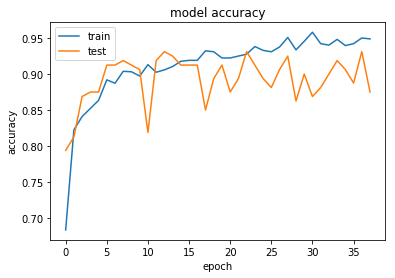

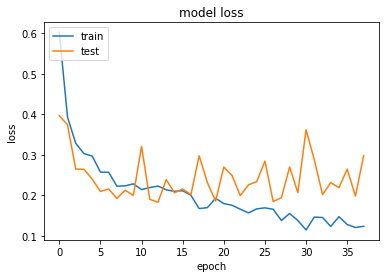

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

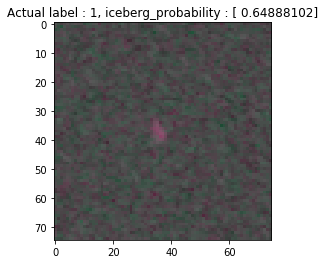

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

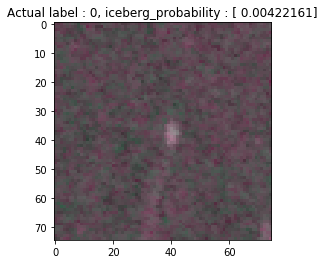

In [18]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

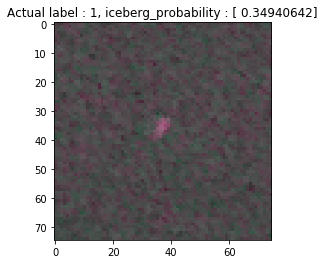

In [19]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

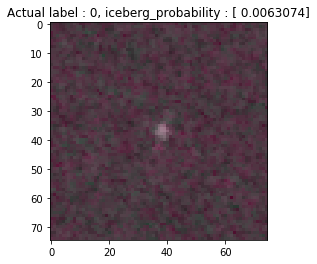

In [20]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

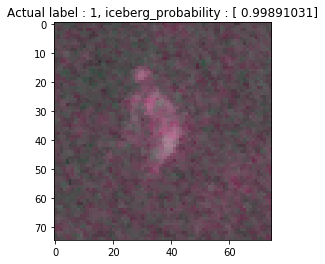

In [21]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

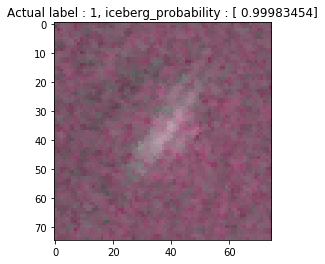

In [22]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)

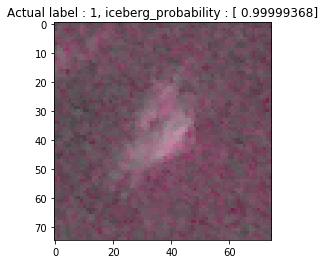

In [23]:
plt.imshow(X_holdout2[10], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[141])+ ","+" iceberg_probability : "+str(pred_valid[10])
plt.title(tl)

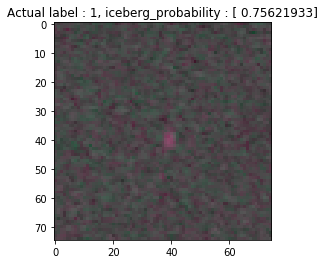

In [24]:
plt.imshow(X_holdout2[11], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[167])+ ","+" iceberg_probability : "+str(pred_valid[11])
plt.title(tl)

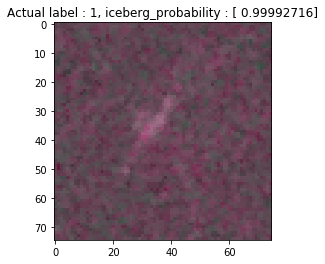

In [25]:
plt.imshow(X_holdout2[12], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[195])+ ","+" iceberg_probability : "+str(pred_valid[12])
plt.title(tl)

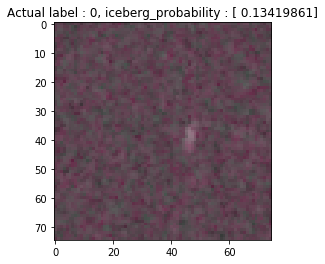

In [26]:
plt.imshow(X_holdout2[13], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[199])+ ","+" iceberg_probability : "+str(pred_valid[13])
plt.title(tl)